In [0]:
#!pip install mnist

In [0]:
import numpy as np
import cv2
import random
import occlusion
import matplotlib.pyplot as plt
from PIL import Image
random.seed(1)
np.random.seed(1)

In [0]:
def preprocess(img, size, patchCorner=(0, 0), patchDim=None, unskew=True):
    """
    Resizes, crops, and unskewes images
  
    """
    if patchDim == None: patchDim = size
    nImg = np.shape(img)[0]
    procImg = np.empty((nImg, size[0], size[1]))

    # Unskew and Resize
    if unskew == True:
        for i in range(nImg):
            procImg[i, :, :] = deskew(cv2.resize(img[i, :, :], size), size)

    # Crop
    cropImg = np.empty((nImg, patchDim[0], patchDim[1]))
    for i in range(nImg):
        cropImg[i, :, :] = procImg[i, patchCorner[0]:patchCorner[0] + patchDim[0], \
                           patchCorner[1]:patchCorner[1] + patchDim[1]]
    procImg = cropImg

    return procImg


def deskew(image, image_shape, negated=True):
    """
    This method deskwes an image using moments
    :param image: a numpy nd array input image
    :param image_shape: a tuple denoting the image`s shape
    :param negated: a boolean flag telling whether the input image is negated
  
    :returns: a numpy nd array deskewd image
  
    source: https://github.com/vsvinayak/mnist-helper
    """

    # negate the image
    if not negated:
        image = 255 - image
    # calculate the moments of the image
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        return image.copy()
    # caclulating the skew
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * image_shape[0] * skew], [0, 1, 0]])
    img = cv2.warpAffine(image, M, image_shape, flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

def mnist_256():
  ''' 
  Converts 28x28 mnist digits to [16x16] 
  [samples x pixels]  ([N X 256])
  '''  
  import mnist
  z = (mnist.train_images()/255)
  z = preprocess(z,(16,16))

  z = z.reshape(-1, (256))
  return z, mnist.train_labels()

def mnist_256_test():
  ''' 
  Converts 28x28 mnist digits to [16x16] 
  [samples x pixels]  ([N X 256])
  '''  
  import mnist
  z = (mnist.test_images()/255)
  z = preprocess(z,(16,16))

  z = z.reshape(-1, (256))
  return z, mnist.test_labels()

test = mnist_256_test()
train = mnist_256()


In [0]:
x_train = train[0]
y_train = train[1]
x_test = test[0]
y_test = test[1]
x_train = x_train.reshape(60000, 16, 16)
x_test = x_test.reshape(10000, 16, 16)

In [5]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 16, 16

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


x_train shape: (60000, 16, 16, 1)
60000 train samples
10000 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

W0829 14:47:29.942825 139803654469504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 14:47:29.957743 139803654469504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 14:47:29.960585 139803654469504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 14:47:29.985573 139803654469504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0829 14:47:29.987972 139803654469504 deprecation_wrapp

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 6s 92us/step - loss: 0.2751 - acc: 0.9162 - val_loss: 0.0644 - val_acc: 0.9788
Epoch 2/12
60000/60000 [==============================] - 3s 44us/step - loss: 0.0949 - acc: 0.9715 - val_loss: 0.0388 - val_acc: 0.9872
Epoch 3/12
60000/60000 [==============================] - 3s 44us/step - loss: 0.0728 - acc: 0.9777 - val_loss: 0.0352 - val_acc: 0.9874
Epoch 4/12
60000/60000 [==============================] - 3s 45us/step - loss: 0.0607 - acc: 0.9818 - val_loss: 0.0284 - val_acc: 0.9901
Epoch 5/12
60000/60000 [==============================] - 3s 44us/step - loss: 0.0535 - acc: 0.9840 - val_loss: 0.0274 - val_acc: 0.9901
Epoch 6/12
60000/60000 [==============================] - 3s 44us/step - loss: 0.0472 - acc: 0.9858 - val_loss: 0.0258 - val_acc: 0.9907
Epoch 7/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.0445 - acc: 0.9871 - val_loss: 0.0232 - val_acc

In [0]:
hdm = occlusion.HausdorffDistanceMasks(16, 16)
hdm.generate_masks(1, 1)

label: 6
prediction 6


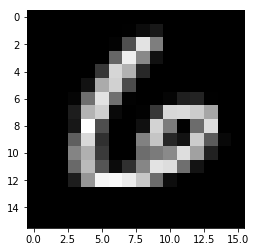

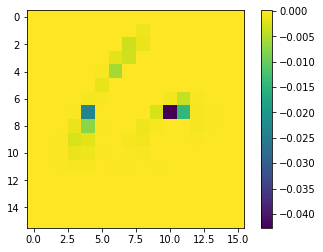

label: 9
prediction 9


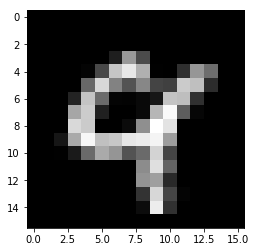

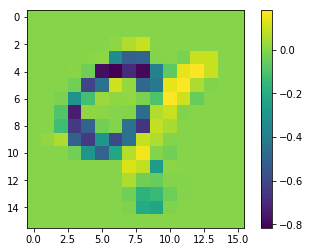

label: 2
prediction 2


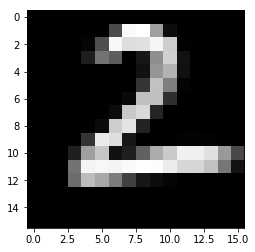

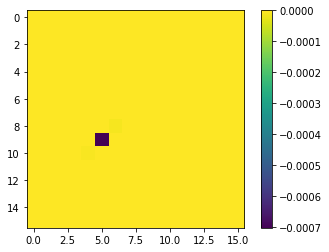

label: 6
prediction 6


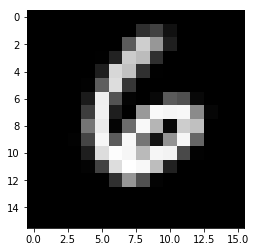

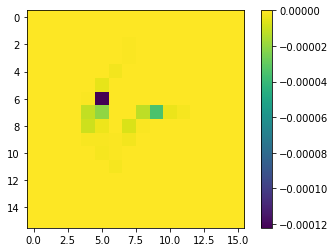

label: 7
prediction 7


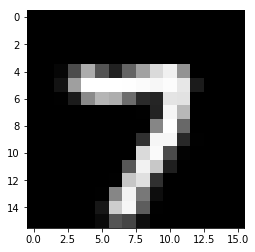

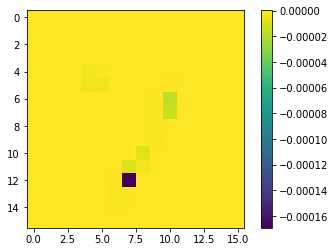

label: 6
prediction 6


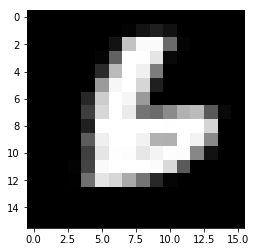

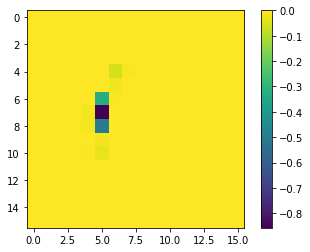

label: 1
prediction 1


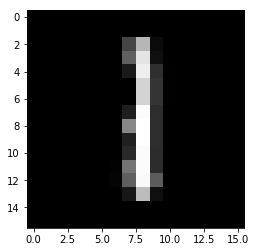

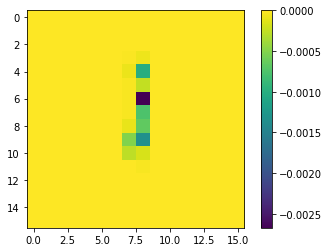

label: 4
prediction 4


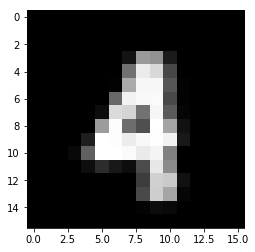

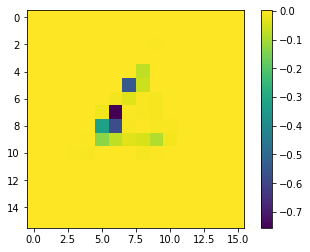

label: 7
prediction 7


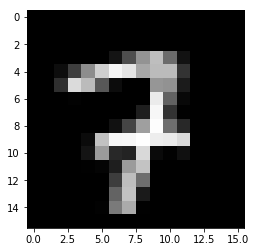

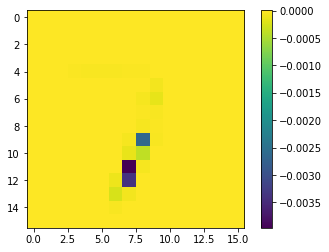

label: 1
prediction 1


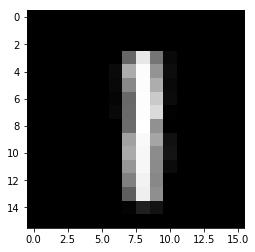

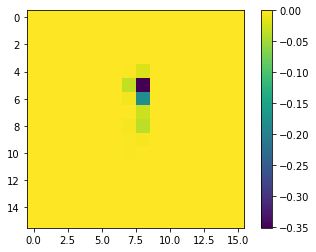

In [17]:
for index in [9953, 3850, 4962, 3886, 5437, 8517, 2041, 1989, 1933, 9984]:
    image = x_test[index].reshape(16, 16)

    label = np.argmax(y_test[index])
    print('label:', label)

    baseline = model.predict(image.reshape(1, 16, 16, 1))

    print('prediction', np.argmax(baseline[0]))

    result = hdm.explain(model, image, baseline[0], output_class=label)

    plt.imshow(image, cmap='Greys_r')
    plt.show()

    img = plt.imshow(result.distances(occlusion.RAW))
    plt.colorbar(img)
    plt.show()